In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import tensorflow as tf

# Shot Boundaries 

In [28]:
def detect_shot_boundaries(video_path, threshold=10):

    videoStruct = {}
    cap = cv2.VideoCapture(video_path)

    prev_frame = None
    frame_diffs = [0]
    # frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if prev_frame is not None:
            diff = cv2.absdiff(gray, prev_frame)
            frame_diffs.append(diff.mean())
            # frames.append(frame)

        prev_frame = gray

    avg_diff = sum(frame_diffs) / len(frame_diffs)

    # shot_boundaries = []
    counter = 1
    for i, diff in enumerate(frame_diffs):
        if diff > threshold * avg_diff:
            # videoStruct[str(counter)] = np.asarray([[i], frames[i]])
            # plt.imshow(frames[i])
            # plt.show()
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            videoStruct[str(counter)] = (i,frame)
            counter += 1

    # cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    # current_shot = 0
    # while cap.isOpened():
    #     ret, frame = cap.read()
    #     if not ret:
    #         break

    #     if current_shot < len(shot_boundaries) and \
    #             shot_boundaries[current_shot] == cap.get(cv2.CAP_PROP_POS_FRAMES):
    #         cv2.line(frame, (0, 0), (0, frame.shape[0]), (0, 0, 255), thickness=3)
    #         current_shot += 1

    #     cv2.imshow('Video with shot boundaries', frame)
    #     if cv2.waitKey(25) & 0xFF == ord('q'):
    #         break
    # cap.release()
    cv2.destroyAllWindows()

    return videoStruct

In [29]:
# vidPath = './project/episodes/BBTS1E1.mp4'
vidPath = './project/data/BBT_S1_E1.mp4'

shot_boundaries = detect_shot_boundaries(vidPath)
print(shot_boundaries)

{'1': (46, array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)), '2': (82, array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0

# Shot Threading 

In [30]:
def thread_shots_with_sift_matching(shot_boundaries, threshold=0.5, num_frames_per_thread=25):
    sift = cv2.SIFT_create()
    threads = []
    done_thread = np.zeros(len(shot_boundaries))

    # cap = cv2.VideoCapture(video_path)
    for i in range(len(shot_boundaries) - 1):
        if done_thread[i] == 1:
            continue
        # cap.set(cv2.CAP_PROP_POS_FRAMES, shot_boundaries[i])
        # ret, last_frame = cap.read()
        last_frame = shot_boundaries[str(i+1)][1]
        last_frame_features = sift.detectAndCompute(last_frame, None)[1]

        if last_frame_features is None:
            continue

        present_thread = [i]
        # present_thread = []
        thread_scores = {i: 0}
        

        for j in range(i + 1, min(i + num_frames_per_thread, len(shot_boundaries))):
            if done_thread[j] == 1:
                continue
            # cap.set(cv2.CAP_PROP_POS_FRAMES, shot_boundaries[j] + 1)
            # ret, next_frame = cap.read()
            next_frame = shot_boundaries[str(j+1)][1]
            next_frame_features = sift.detectAndCompute(next_frame, None)[1]

            if next_frame_features is None:
                continue
            
            print(i,j)

            bf = cv2.BFMatcher()
            matches = bf.knnMatch(last_frame_features, next_frame_features, k=2)

            good = []
            for m, n in matches:
                if m.distance < threshold * n.distance:
                    good.append([m])

            score = len(good)
            thread_scores[j] = score

            if score > threshold * num_frames_per_thread:
                present_thread.append(j)
                done_thread[j] = 1
                # last_frame_features = next_frame_features

        threads.append(present_thread)
        done_thread[i] = 1

    # cap.release()

    return threads

In [31]:
threads = thread_shots_with_sift_matching(shot_boundaries)

print(threads)

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
1 2
1 3
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 13
1 14
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
2 5
2 7
2 9
2 10
2 13
2 17
2 18
2 19
2 21
2 23
2 25
2 26
9 10
9 18
9 19
9 26
9 27
9 28
9 29
9 30
9 31
9 32
9 33
10 18
10 19
10 26
10 27
10 28
10 29
10 30
10 31
10 32
10 33
10 34
18 27
18 28
18 29
18 30
18 31
18 32
18 33
18 35
18 36
18 37
18 38
18 39
18 40
18 41
18 42
27 28
27 29
27 31
27 32
27 33
27 35
27 36
27 37
27 38
27 39
27 40
27 41
27 42
27 43
27 44
27 45
27 46
27 47
27 48
27 49
27 50
27 51
28 29
28 31
28 32
28 33
28 36
28 38
28 39
28 40
28 42
28 43
28 44
28 45
28 46
28 47
28 48
28 49
28 50
28 51
28 52
29 31
29 33
29 38
29 39
29 40
29 42
29 44
29 45
29 46
29 47
29 48
29 49
29 50
29 51
29 52
29 53
39 40
39 45
39 46
39 47
39 48
39 49
39 50
39 51
39 52
39 53
39 54
39 55
40 45
40 46
40 48
40 49
40 50
40 51
40 52
40 53
40 54
40 55
46 48
46 49
46 51
46 53
46 54
46 55
48 49
48 51
4

In [32]:
def make_adjacency_matrix(threads, numShots):
    
    adj_mat = np.zeros((numShots, numShots))
    for thread in threads:
        for i in range(len(thread) - 1):
            for j in range(i + 1, len(thread)):
             adj_mat[thread[i]][thread[j]] = 1
             adj_mat[thread[j]][thread[i]] = 1
    return adj_mat

numShots = len(shot_boundaries)
adj_mat = make_adjacency_matrix(threads, numShots)
print(adj_mat)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [33]:
print(adj_mat.shape)

(56, 56)


# Shot Representation 

In [34]:
def shot_histogram(shot, visualize = True):
    # shot_hist = np.zeros((6, 6, 6), dtype=np.float32)
    bin_size = 42
    num_bins = 256 // bin_size

    pixels = shot.reshape(-1, 3)

    # r_bins = pixels[:, 0] // bin_size
    # g_bins = pixels[:, 1] // bin_size
    # b_bins = pixels[:, 2] // bin_size

    shot_hist = np.zeros((6, 6, 6), dtype=np.float32)
    r_bins = pixels[:, 0] // bin_size
    g_bins = pixels[:, 1] // bin_size
    b_bins = pixels[:, 2] // bin_size

    r_indices = r_bins - 1
    g_indices = g_bins - 1
    b_indices = b_bins - 1

    mask = (r_indices >= 0) & (r_indices < num_bins) & (g_indices >= 0) & (g_indices < num_bins) & (b_indices >= 0) & (b_indices < num_bins)
    # print(mask)

    # Use the mask and the indices to update the histogram array
    np.add.at(shot_hist, (r_indices[mask], g_indices[mask], b_indices[mask]), 1)

        

    if visualize:
        plt.figure(figsize=(10, 10))
        # plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(shot, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        # plt.subplot(1, 2, 2)
        x, y, z = np.indices(shot_hist.shape)
        x = x.flatten()
        y = y.flatten()
        z = z.flatten()
        colors = np.array([shot_hist[x[i], y[i], z[i]] for i in range(len(x))])
        # Create a 3D scatter plot of the data
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, c=colors,s=10,  marker='o')
        ax.set_xlabel('Red bins')
        ax.set_ylabel('Green bins')
        ax.set_zlabel('Blue bins')
        plt.show()

    return shot_hist

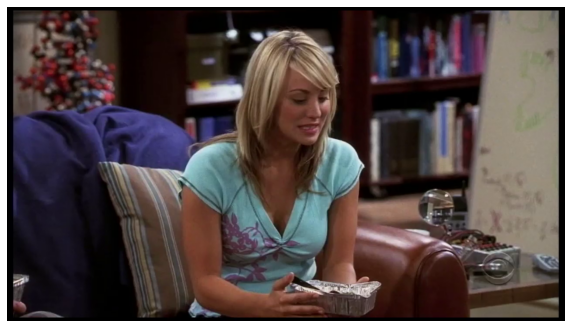

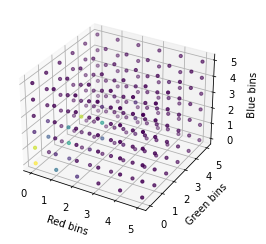

In [35]:
x = shot_histogram(shot_boundaries['5'][1])

In [36]:
def shot_dist_set(shot, P, shot_boundaries):
    numShots = len(P)
    dist = 0
    shotHist = shot_histogram(shot_boundaries[str(shot+1)][1], visualize=False)
    for i in range(numShots):
        tempHist = shot_histogram(shot_boundaries[str(P[i]+1)][1], visualize=False)
        dist += cv2.compareHist(shotHist, tempHist, cv2.HISTCMP_BHATTACHARYYA)
    return dist / numShots  

In [37]:
print(shot_dist_set(4, threads[0], shot_boundaries))
print(shot_dist_set(0, threads[11], shot_boundaries))

0.08669053557071531
0.3805630586977878


# Scene Detection 

In [38]:
def thread_score(shot, P, adj_mat):
    # print(len(P))
    score = 0
    for i in range(len(P)):
        if adj_mat[shot][P[i]] == 1:
            return 1
            # score += 1
    return 0

In [39]:
def alphas(k, Nl):
 return 1-((k/Nl)**2)*0.5

In [40]:
def dynamic_score(shot_boundaries, shot, P, adj_mat, Nl = 35):
    score = alphas(shot, Nl)*(thread_score(shot, P, adj_mat) + shot_dist_set(shot, P, shot_boundaries))
    return score

In [41]:
def scene_detection(Nsc, Nl, shot_boundaries, adj_mat):
    Nsh = len(shot_boundaries)
    D = np.zeros((Nsc, Nsh, Nl))

    for i in range(Nsc):
        for j in range(1, Nsh):
            for k in range(1, Nl):
                P = np.arange(j-k+1, k)
                D[i, j, k] = D[i, j-1, k-1] + alphas(k, Nl) * (shot_dist_set(j, P, shot_boundaries) + thread_score(j, P, adj_mat))

    for i in range(Nsc):
        for j in range(1, Nsh):
            D[i, j, 0] = max(D[i, j-1, k] + (1-alphas(k, Nl))(1-shot_dist_set(k, P, shot_boundaries)+(1 - thread_score(k, P, adj_mat))) for k in range(1, Nl))

    scene_boundaries = []
    for i in range(Nsc):
        scene_boundaries.append(np.argmax(D[i, Nsh-1, :]))

    return scene_boundaries


In [42]:
def scene_detection(Nsc, shot_boundaries, adj_mat, scene_boundaries, prevk=0):
    prev_score = 0
    k_optimal = -1
    # best_score = -1
    # k_best = -1
    if(Nsc == 1):
        return scene_boundaries
    elif(len(shot_boundaries)==1):
        return scene_boundaries
    for k in range(1, len(shot_boundaries)+1):
        P = []
        Q = []
        for i in range(k):
            P.append(i+prevk)
        for i in range(k+1, len(shot_boundaries)-1):
            Q.append(i+prevk)
        # print(P)
        # print(shot_boundaries.keys())
        score1 = dynamic_score(shot_boundaries, k+prevk-1, P, adj_mat)
        score2 = dynamic_score(shot_boundaries, k+prevk-1, Q, adj_mat)
        score = score1 + score2

        # if score > best_score:
        #     best_score = score
        #     k_best = k+prevk

    # scene_boundaries.append(k_best)
    # scene2 = {}
    # for i in range(k_best, len(shot_boundaries)):
    #     scene2[str(i)] = shot_boundaries[str(i)]
    # scene_boundaries = scene_detection(Nsc-1, scene2, adj_mat, scene_boundaries,k_best)                
        if score > prev_score:
            k_optimal = k+prevk

        else:
            print(Nsc)
            scene_boundaries.append(k_optimal)
            scene2 = {}
            print(k_optimal)
            for i in range(k_optimal, len(shot_boundaries)):
                scene2[str(i)] = shot_boundaries[str(i)]
            else:
                scene_boundaries = scene_detection(Nsc-1, scene2, adj_mat, scene_boundaries,k_optimal)
                break
        prev_score = score
    return scene_boundaries

In [43]:
scene_boundaries = []
scene_boundaries = scene_detection(5, 10, shot_boundaries, adj_mat)

TypeError: object of type 'int' has no len()

In [ ]:
scene_boundaries

[4, 9, 12, 17]

In [ ]:
threads

[[0, 4, 12, 15],
 [1, 3, 6, 8, 11, 14, 16, 20, 22, 24],
 [2, 5, 7, 13, 17, 21, 23, 25],
 [9],
 [10, 19, 26, 34],
 [18, 30],
 [27, 35, 37, 41],
 [28, 32, 36, 43],
 [29, 31, 33, 38, 42, 44],
 [39, 47],
 [40, 45, 50, 52],
 [46],
 [48],
 [49, 51, 53, 55],
 [54]]

# Face Recognition

In [ ]:
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./images"))

# Any results you write to the current directory are saved as output.

['leonard', 'penny', 'sheldon']


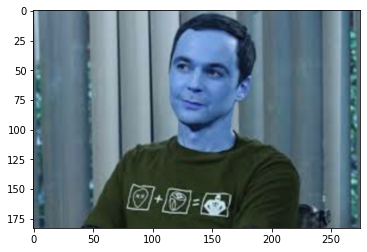

(183, 275, 3)


In [4]:
img = cv2.imread('./images/sheldon/1.jpeg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(img.shape)

In [53]:
# extract a single face from a given photograph
def extract_face(image, required_size=(160, 160)):
    # load image from file
    # image = Image.open(filename)
    # convert to RGB, if needed
    # image = image.convert('RGB')
    
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # if no faces are detected then return None
    if len(results) == 0:
        return None
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array


In [54]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
# trainX, trainy = load_dataset('./images/')
# print(trainX.shape, trainy.shape)
# # load test dataset
# testX, testy = load_dataset('./test/')
# print(testX.shape, testy.shape)

# # save and compress the dataset for further use
# np.savez_compressed('dataset.npz', trainX, trainy, testX, testy)

In [7]:
data = np.load('dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (19, 160, 160, 3) (19,) (4, 160, 160, 3) (4,)


In [19]:
from keras_facenet import FaceNet

In [55]:
facenet_model = FaceNet()
print('Loaded Model')

Loaded Model


In [56]:
def get_embedding(model, face):
    # scale pixel values
    # face = face.astype('float32')
    # standardization
    # mean, std = face.mean(), face.std()
    # face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.embeddings(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('embeddings.npz', emdTrainX, trainy, emdTestX, testy)

1/1 [==============================] - 0s 74ms/step
(19, 512)
1/1 [==============================] - 0s 74ms/step
(4, 512)


In [11]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=19, test=4
Accuracy: train=100.000, test=100.000


In [59]:
charecters = []

for i in range(len(shot_boundaries)):
    image = shot_boundaries[str(i+1)][1]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pixels = extract_face(image)
    if pixels is None:
        charecters.append('None')
        continue
    embedding = get_embedding(facenet_model, pixels)
    embedding_norm = in_encoder.transform(np.expand_dims(embedding, axis=0))
    yhat_class = model.predict(embedding_norm)
    charecters.append(out_encoder.inverse_transform(yhat_class)[0])


1/1 [==============================] - 0s 64ms/step


In [60]:
len(charecters)

56

In [61]:
charecters

['penny',
 'leonard',
 'penny',
 'leonard',
 'penny',
 'sheldon',
 'leonard',
 'sheldon',
 'leonard',
 'penny',
 'sheldon',
 'leonard',
 'penny',
 'sheldon',
 'leonard',
 'penny',
 'leonard',
 'sheldon',
 'leonard',
 'sheldon',
 'leonard',
 'penny',
 'leonard',
 'sheldon',
 'sheldon',
 'sheldon',
 'sheldon',
 'penny',
 'leonard',
 'penny',
 'leonard',
 'sheldon',
 'leonard',
 'penny',
 'penny',
 'penny',
 'leonard',
 'penny',
 'sheldon',
 'leonard',
 'sheldon',
 'penny',
 'sheldon',
 'leonard',
 'sheldon',
 'penny',
 'None',
 'leonard',
 'sheldon',
 'penny',
 'leonard',
 'penny',
 'sheldon',
 'penny',
 'leonard',
 'penny']

# Loss Functions

In [73]:
def cooccurance(c1, c2, scene1, scene2, charecters):
    count1 = 0
    count2 = 0
    for i in range(scene1, scene2):
        if charecters[i] == c1:
            count1 += 1
        elif charecters[i] == c2:
            count2 += 1
    # geometric mean of count1 and 2
    return np.sqrt(count1*count2)

In [74]:
def proximity(Np, Nt, chars, scene1, scene2, charecters, x ):
    Nc = len(chars)
    sum = 0
    for i in range(Nc):
        for j in range(i+1, Nc):
            char1 = chars[i]
            char2 = chars[j]
            cooccur = cooccurance(char1, char2, scene1, scene2, charecters)
            sum += cooccur*((x[i]-x[j])**2)
    L1 = sum/(Np*Nt)

    sum = 0
    for i in range(Nc):
        for j in range(i+1, Nc):
            char1 = chars[i]
            char2 = chars[j]
            cooccur = cooccurance(char1, char2, scene1, scene2, charecters)
            sum += (cooccur==0)*((x[i]-x[j])**2)

    L2 = sum/(Np*Nt)
    return L1-L2


In [75]:
def straightLines(Nc, Nt, mu, x):
    sum = 0
    for i in range(Nc):
        sum += (x[i]-mu[i])**2
    return sum/(Nc*Nt)

In [76]:
def z(x, mu):
    resZ = 0
    if x<mu:
        resZ = (1/x)*(np.sqrt(1+(x-mu)**2)-1)
    return resZ

def minSeparation(Np, Nt, muS, x):
    Ls = 0
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            Ls += z((x[i]-x[j])**2, muS)
    return Ls/(Np*Nt)

In [92]:

chars = ['leonard', 'penny', 'sheldon']
Nsc = 2
Nt = Nsc
muS = 0.3

def objectiveFun(x):
    Nc = len(x)
    Np = Nc*(Nc-1)/2

    return proximity(Np, Nt, chars, scene1, scene2, charecters, x) + minSeparation(Np, Nt, muS, x)

In [91]:
scene_boundaries = [45, 56]

In [79]:
from scipy.optimize import minimize

In [ ]:
x0 = []
res = minimize(objectiveFun, x0, method='nelder-mead', options={'disp': True})

In [111]:
scene1 = 0
coordinates = []
bounds = [(1, len(chars))]*len(chars)
x0 = np.array([1, 2, 3])
for i in range(Nsc):
    print("Scene: ", i)
    scene2 = scene_boundaries[i]
    res = minimize(objectiveFun, x0, bounds=bounds, method='Nelder-Mead', options={'disp': True})
    x0 = res.x
    coordinates.append(res.x)
    scene1 = scene2

Scene:  0
Optimization terminated successfully.
         Current function value: 0.857868
         Iterations: 59
         Function evaluations: 113
Scene:  1
Optimization terminated successfully.
         Current function value: 0.345075
         Iterations: 42
         Function evaluations: 81


C:\Users\sreen\AppData\Local\Temp\ipykernel_17092\379140935.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  resZ = (1/x)*(np.sqrt(1+(x-mu)**2)-1)


In [112]:
res

 final_simplex: (array([[2.73449026, 2.48037869, 3.        ],
       [2.73454193, 2.48044815, 3.        ],
       [2.73455866, 2.48033812, 3.        ],
       [2.73445982, 2.48034253, 3.        ]]), array([0.34507468, 0.34507469, 0.3450747 , 0.3450747 ]))
           fun: 0.34507468412518894
       message: 'Optimization terminated successfully.'
          nfev: 81
           nit: 42
        status: 0
       success: True
             x: array([2.73449026, 2.48037869, 3.        ])

In [113]:
coordinates

[array([2.81882785, 2.6369067 , 3.        ]),
 array([2.73449026, 2.48037869, 3.        ])]

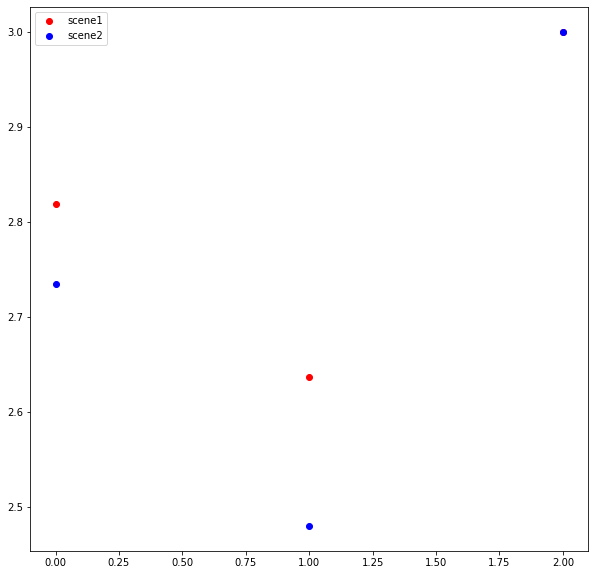

In [117]:
# plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(coordinates[0], 'ro', label='scene1')
plt.plot(coordinates[1], 'bo', label='scene2')
plt.legend()
plt.show()
